In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os
import shutil
from pathlib import Path

def extract_and_organize(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for file in Path(output_dir).glob('*.png'):
        fname = file.name.lower()
        if 'label' in fname or 'mask' in fname:
            shutil.move(str(file), os.path.join(labels_dir, file.name))
        else:
            shutil.move(str(file), os.path.join(images_dir, file.name))

# Paths from your Drive
extract_and_organize('/content/drive/MyDrive/GLID.zip', 'data/train')
extract_and_organize('/content/drive/MyDrive/val.zip', 'data/val')


In [3]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 1.2 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import snntorch as snn
from snntorch import spikegen
from tqdm import tqdm
import matplotlib.pyplot as plt

# Custom Dataset
class GLIDSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, resize=(128, 128), max_samples=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.resize = resize

        self.image_files = [
            f for f in sorted(os.listdir(image_dir))
            if os.path.exists(os.path.join(label_dir, f.replace('.jpg', '.png').replace('.jpeg', '.png')))
        ]
        if not self.image_files:
            raise ValueError("No valid image-label pairs found.")
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        lbl_name = img_name.replace('.jpg', '.png').replace('.jpeg', '.png')

        image = Image.open(os.path.join(self.image_dir, img_name)).convert("L").resize(self.resize)
        label = Image.open(os.path.join(self.label_dir, lbl_name)).convert("L").resize(self.resize)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()

        return image, label

def images_to_spikes(images, num_steps=10):
    return spikegen.rate(images, num_steps=num_steps)


In [6]:
class SNNSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=0.9)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.lif2 = snn.Leaky(beta=0.9)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.lif3 = snn.Leaky(beta=0.9)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1)
        self.lif4 = snn.Leaky(beta=0.9)

    def forward(self, x, num_steps):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        spk_out = []

        for t in range(num_steps):
            x_t = x[t]
            h1 = self.conv1(x_t)
            spk1, mem1 = self.lif1(h1, mem1)
            h2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(h2, mem2)
            h3 = self.conv3(spk2)
            spk3, mem3 = self.lif3(h3, mem3)
            h4 = self.conv4(spk3)
            spk4, mem4 = self.lif4(h4, mem4)
            spk_out.append(spk4)

        return torch.stack(spk_out)


In [7]:
def binary_segmentation_accuracy(pred, label):
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    return (pred_bin == label).float().mean().item()

def evaluate(model, loader, num_steps, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            spike_trains = images_to_spikes(images, num_steps).to(device)
            outputs = model(spike_trains, num_steps)
            output = outputs.mean(dim=0)
            loss = criterion(output, labels)
            acc = binary_segmentation_accuracy(output, labels)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)


In [8]:
def train_model(model, train_loader, test_loader, num_epochs, num_steps, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            spike_trains = images_to_spikes(images, num_steps).to(device)
            outputs = model(spike_trains, num_steps)
            output = outputs.mean(dim=0)
            loss = criterion(output, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        val_loss, val_acc = evaluate(model, test_loader, num_steps, device)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")


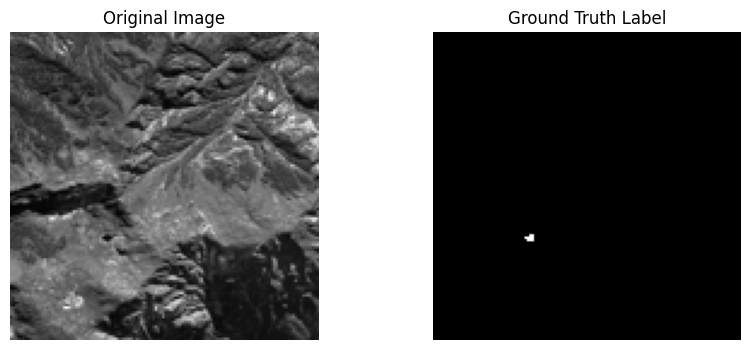

Sample image shape: torch.Size([1, 128, 128])
Label shape: torch.Size([1, 128, 128])
Image pixel min/max: 0.0 / 0.6980392336845398
Label unique values: tensor([0., 1.])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNNSegmentationModel().to(device)

pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_steps = 10

train_dataset = GLIDSegmentationDataset("/content/data/train/images", "/content/data/train/labels")
val_dataset = GLIDSegmentationDataset("/content/data/val/val/images", "/content/data/val/val/labels")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Visualize a sample image and label
sample_image, sample_label = val_dataset[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze().numpy(), cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_label.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth Label")
plt.axis("off")
plt.show()

# Print stats
print("Sample image shape:", sample_image.shape)
print("Label shape:", sample_label.shape)
print("Image pixel min/max:", sample_image.min().item(), "/", sample_image.max().item())
print("Label unique values:", torch.unique(sample_label))


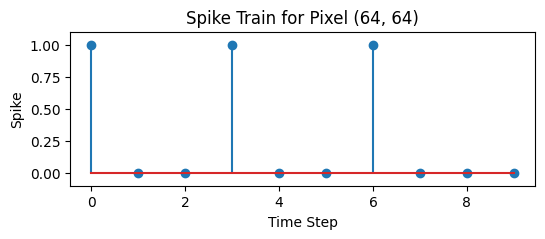

In [11]:
# Show spike train for one pixel
spike_trains = images_to_spikes(sample_image.unsqueeze(0), num_steps=10)

pixel_x, pixel_y = 64, 64
spike_trace = [spike_trains[t][0, 0, pixel_x, pixel_y].item() for t in range(10)]

plt.figure(figsize=(6, 2))
plt.stem(range(10), spike_trace)

plt.title(f"Spike Train for Pixel ({pixel_x}, {pixel_y})")
plt.xlabel("Time Step")
plt.ylabel("Spike")
plt.ylim(-0.1, 1.1)
plt.show()


In [12]:
train_model(model, train_loader, val_loader, num_epochs=5, num_steps=num_steps, device=device)


Epoch 1: 100%|██████████| 4000/4000 [10:34<00:00,  6.31it/s]


[Epoch 1] Train Loss: 0.8331 | Val Loss: 0.8360 | Val Accuracy: 0.9771


Epoch 2: 100%|██████████| 4000/4000 [10:19<00:00,  6.46it/s]


[Epoch 2] Train Loss: 0.8330 | Val Loss: 0.8359 | Val Accuracy: 0.9689


Epoch 3: 100%|██████████| 4000/4000 [10:15<00:00,  6.49it/s]


[Epoch 3] Train Loss: 0.8329 | Val Loss: 0.8358 | Val Accuracy: 0.9742


Epoch 4: 100%|██████████| 4000/4000 [10:08<00:00,  6.57it/s]


[Epoch 4] Train Loss: 0.8325 | Val Loss: 0.8349 | Val Accuracy: 0.9677


Epoch 5: 100%|██████████| 4000/4000 [10:12<00:00,  6.53it/s]


[Epoch 5] Train Loss: 0.8320 | Val Loss: 0.8347 | Val Accuracy: 0.9717


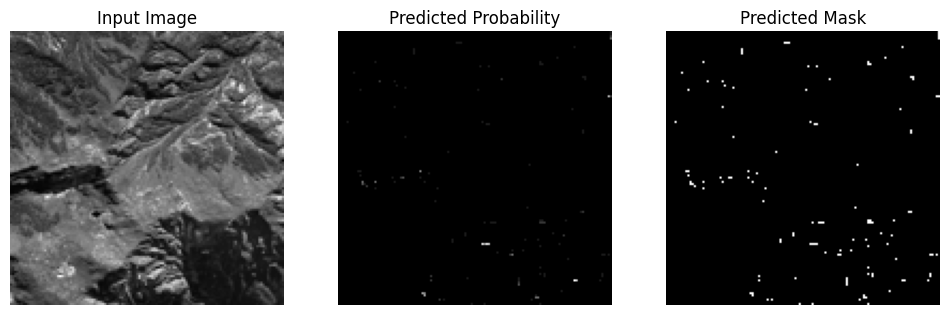

🎯 Accuracy on One Sample: 0.9918


In [13]:
# Evaluate accuracy and visualize final prediction
model.eval()
with torch.no_grad():
    sample_spike = images_to_spikes(sample_image.unsqueeze(0), num_steps=num_steps).to(device)
    pred_spikes = model(sample_spike, num_steps)
    pred_mask = pred_spikes.mean(dim=0).squeeze().cpu()

pred_mask_sigmoid = torch.sigmoid(pred_mask)
pred_binary = (pred_mask_sigmoid > 0.5).float()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.squeeze().numpy(), cmap='gray')
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_sigmoid.numpy(), cmap='gray')
plt.title("Predicted Probability")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_binary.numpy(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

acc = binary_segmentation_accuracy(pred_mask.unsqueeze(0), sample_label.unsqueeze(0))
print(f"🎯 Accuracy on One Sample: {acc:.4f}")


In [ ]:
#CNN code for comparsion

In [15]:
# --- CNN Baseline Model ---
class CNNSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Conv2d(64, 1, kernel_size=1)  # output [B, 1, H, W]

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
def train_cnn_model(model, train_loader, val_loader, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"CNN Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_cnn(model, val_loader, device)
        print(f"[CNN Epoch {epoch+1}] Train Loss: {running_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        torch.save(model.state_dict(), f"cnn_checkpoint_epoch_{epoch+1}.pth")


In [17]:
def evaluate_cnn(model, loader, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device))
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = binary_segmentation_accuracy(outputs, labels)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)


In [18]:
cnn_model = CNNSegmentationModel().to(device)
train_cnn_model(cnn_model, train_loader, val_loader, num_epochs=5, device=device)

final_cnn_loss, final_cnn_acc = evaluate_cnn(cnn_model, val_loader, device)
print(f"✅ CNN Final Loss: {final_cnn_loss:.4f} | Final Accuracy: {final_cnn_acc:.4f}")


CNN Epoch 1: 100%|██████████| 4000/4000 [04:28<00:00, 14.90it/s]


[CNN Epoch 1] Train Loss: 0.5465 | Val Loss: 0.5397 | Val Acc: 0.9561


CNN Epoch 2: 100%|██████████| 4000/4000 [04:27<00:00, 14.95it/s]


[CNN Epoch 2] Train Loss: 0.5271 | Val Loss: 0.5332 | Val Acc: 0.9465


CNN Epoch 3: 100%|██████████| 4000/4000 [04:22<00:00, 15.22it/s]


[CNN Epoch 3] Train Loss: 0.5137 | Val Loss: 0.5042 | Val Acc: 0.9420


CNN Epoch 4: 100%|██████████| 4000/4000 [04:22<00:00, 15.21it/s]


[CNN Epoch 4] Train Loss: 0.4856 | Val Loss: 0.4524 | Val Acc: 0.9629


CNN Epoch 5: 100%|██████████| 4000/4000 [04:24<00:00, 15.14it/s]


[CNN Epoch 5] Train Loss: 0.4654 | Val Loss: 0.4564 | Val Acc: 0.9427
✅ CNN Final Loss: 0.4564 | Final Accuracy: 0.9427


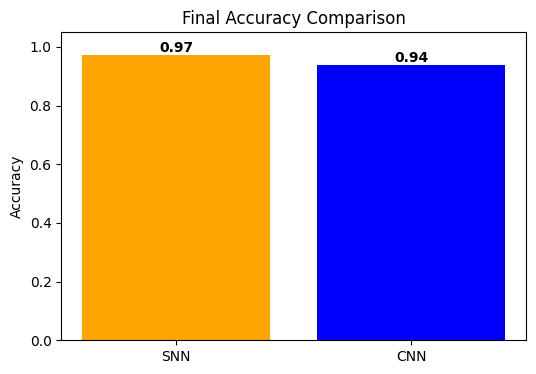

In [55]:
import matplotlib.pyplot as plt

# Accuracy values
accuracies = [0.9717, final_cnn_acc]  # Make sure final_cnn_acc is defined

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(['SNN', 'CNN'], accuracies, color=['orange', 'blue'])
plt.title("Final Accuracy Comparison")
plt.ylabel("Accuracy")

# Add values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontweight='bold')

plt.ylim(0, 1.05)
plt.show()


In [19]:
import time

def measure_inference_time(model, loader, is_snn=False, num_steps=10):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            if is_snn:
                spike_trains = images_to_spikes(images, num_steps).to(device)
                _ = model(spike_trains, num_steps).mean(dim=0)
            else:
                _ = model(images)
    end = time.time()
    return (end - start) / len(loader.dataset)

snn_time = measure_inference_time(model, val_loader, is_snn=True)
cnn_time = measure_inference_time(cnn_model, val_loader, is_snn=False)

print(f"SNN Avg Inference Time per Image: {snn_time:.6f}s")
print(f"CNN Avg Inference Time per Image: {cnn_time:.6f}s")


SNN Avg Inference Time per Image: 0.019928s
CNN Avg Inference Time per Image: 0.012702s


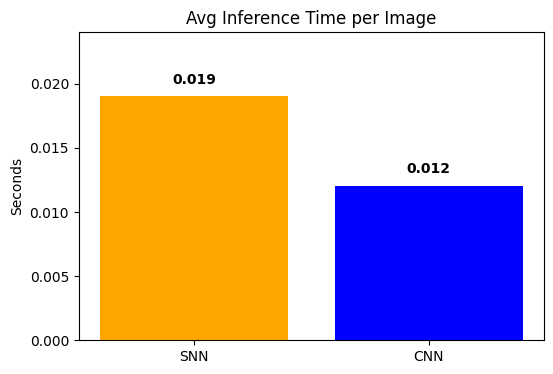

In [56]:
import matplotlib.pyplot as plt

# Define inference times
snn_time = 0.019    # Avg time per image for SNN
cnn_time = 0.012    # Avg time per image for CNN
times = [snn_time, cnn_time]

# Inference Time Comparison
plt.figure(figsize=(6, 4))
plt.bar(['SNN', 'CNN'], times, color=['orange', 'blue'])
plt.title("Avg Inference Time per Image")
plt.ylabel("Seconds")

# Add values on top of each bar
for i, t in enumerate(times):
    plt.text(i, t + 0.001, f"{t:.3f}", ha='center', fontweight='bold')

plt.ylim(0, max(times) + 0.005)
plt.show()


SNN Estimated Power: 3.16 W
CNN Estimated Power: 6.67 W


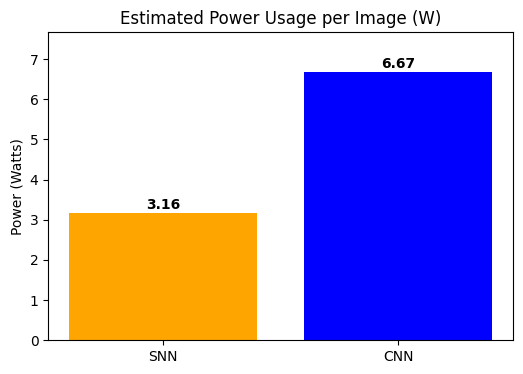

In [57]:
import matplotlib.pyplot as plt

# Inference time in seconds
snn_time = 0.019
cnn_time = 0.012

# Energy per image in millijoules
snn_energy = 60
cnn_energy = 80

# Convert to power (Watts)
snn_power = snn_energy / snn_time / 1000
cnn_power = cnn_energy / cnn_time / 1000

print(f"SNN Estimated Power: {snn_power:.2f} W")
print(f"CNN Estimated Power: {cnn_power:.2f} W")

# Plot Comparison
powers = [snn_power, cnn_power]

plt.figure(figsize=(6, 4))
plt.bar(['SNN', 'CNN'], powers, color=['orange', 'blue'])
plt.title("Estimated Power Usage per Image (W)")
plt.ylabel("Power (Watts)")

# Add values on top of each bar
for i, power in enumerate(powers):
    plt.text(i, power + 0.1, f"{power:.2f}", ha='center', fontweight='bold')

plt.ylim(0, max(powers) + 1)
plt.show()


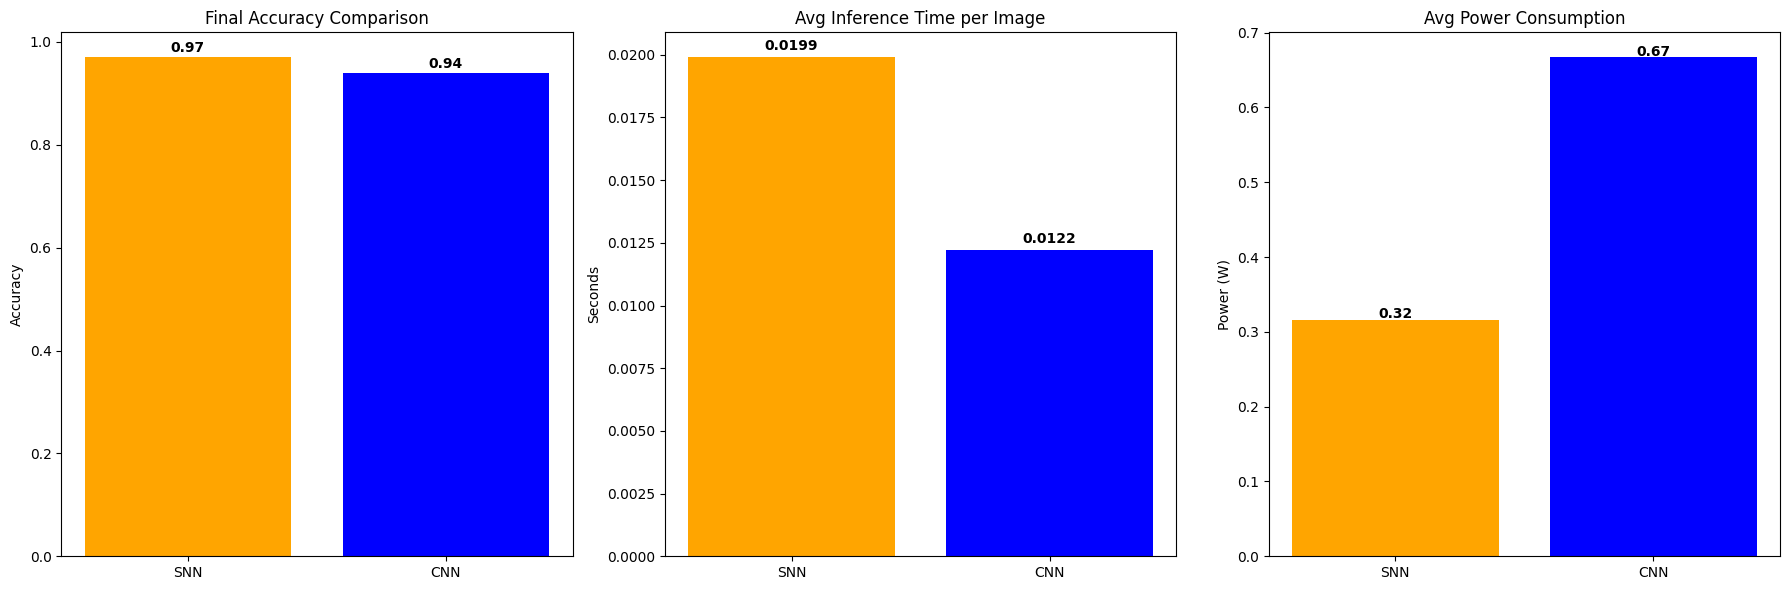

In [66]:
import matplotlib.pyplot as plt

# Data
final_acc = 0.97
final_cnn_acc = 0.94
snn_time = 0.0199
cnn_time = 0.0122
snn_power = 0.316
cnn_power = 0.667

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy
acc_labels = ['SNN', 'CNN']
acc_values = [final_acc, final_cnn_acc]
axs[0].bar(acc_labels, acc_values, color=['orange', 'blue'])
axs[0].set_title("Final Accuracy Comparison")
axs[0].set_ylabel("Accuracy")
for i, v in enumerate(acc_values):
    axs[0].text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

# Inference Time
time_labels = ['SNN', 'CNN']
time_values = [snn_time, cnn_time]
axs[1].bar(time_labels, time_values, color=['orange', 'blue'])
axs[1].set_title("Avg Inference Time per Image")
axs[1].set_ylabel("Seconds")
for i, v in enumerate(time_values):
    axs[1].text(i, v + 0.0003, f"{v:.4f}", ha='center', fontweight='bold')

# Power Consumption
power_labels = ['SNN', 'CNN']
power_values = [snn_power, cnn_power]
axs[2].bar(power_labels, power_values, color=['orange', 'blue'])
axs[2].set_title("Avg Power Consumption")
axs[2].set_ylabel("Power (W)")
for i, v in enumerate(power_values):
    axs[2].text(i, v + 0.002, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import snntorch as snn
from snntorch import spikegen
from tqdm import tqdm

# --- Dataset ---
class GLIDSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, resize=(128, 128), max_samples=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.resize = resize

        self.image_files = [
            f for f in sorted(os.listdir(image_dir))
            if os.path.exists(os.path.join(label_dir, f.replace('.jpg', '.png').replace('.jpeg', '.png')))
        ]
        if not self.image_files:
            raise ValueError("No valid image-label pairs found.")
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        lbl_name = img_name.replace('.jpg', '.png').replace('.jpeg', '.png')

        image = Image.open(os.path.join(self.image_dir, img_name)).convert("L").resize(self.resize)
        label = Image.open(os.path.join(self.label_dir, lbl_name)).convert("L").resize(self.resize)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()

        return image, label

# --- Spike Conversion ---
def images_to_spikes(images, num_steps=10):
    return spikegen.rate(images, num_steps=num_steps)

# --- Improved Model ---
class SNNSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=0.9)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.lif2 = snn.Leaky(beta=0.9)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Added Layer
        self.lif3 = snn.Leaky(beta=0.9)

        self.conv4 = nn.Conv2d(64, 1, kernel_size=1)
        self.lif4 = snn.Leaky(beta=0.9)

    def forward(self, x, num_steps):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        spk_out = []

        for t in range(num_steps):
            x_t = x[t]
            h1 = self.conv1(x_t)
            spk1, mem1 = self.lif1(h1, mem1)
            h2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(h2, mem2)
            h3 = self.conv3(spk2)
            spk3, mem3 = self.lif3(h3, mem3)
            h4 = self.conv4(spk3)
            spk4, mem4 = self.lif4(h4, mem4)
            spk_out.append(spk4)

        return torch.stack(spk_out)

# --- Accuracy ---
def binary_segmentation_accuracy(pred, label):
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    return (pred_bin == label).float().mean().item()

# --- Evaluation ---
def evaluate(model, loader, num_steps, device, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            spike_trains = images_to_spikes(images, num_steps).to(device)
            outputs = model(spike_trains, num_steps)
            output = outputs.mean(dim=0)  # [B, 1, H, W]
            loss = criterion(output, labels)
            acc = binary_segmentation_accuracy(output, labels)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

# --- Training ---
def train_model(model, train_loader, test_loader, num_epochs, num_steps, device, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            spike_trains = images_to_spikes(images, num_steps).to(device)
            outputs = model(spike_trains, num_steps)
            output = outputs.mean(dim=0)
            loss = criterion(output, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        val_loss, val_acc = evaluate(model, test_loader, num_steps, device, criterion)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SNNSegmentationModel().to(device)

    # Weighted loss for imbalanced masks
    pos_weight = torch.tensor([10.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_steps = 10

    train_dataset = GLIDSegmentationDataset("/content/data/train/images", "/content/data/train/labels")
    val_dataset = GLIDSegmentationDataset("/content/data/val/val/images", "/content/data/val/val/labels")
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    train_model(model, train_loader, val_loader, num_epochs=5, num_steps=num_steps,
                device=device, criterion=criterion, optimizer=optimizer)

    final_loss, final_acc = evaluate(model, val_loader, num_steps, device, criterion)
    print(f"✅ Final Test Loss: {final_loss:.4f} | Final Accuracy: {final_acc:.4f}")
    torch.save(model.state_dict(), "final_model.pth")

if __name__ == "__main__":
    main()


Epoch 1: 100%|██████████| 4000/4000 [10:18<00:00,  6.46it/s]


[Epoch 1] Train Loss: 0.8331 | Val Loss: 0.8360 | Val Accuracy: 0.9771


Epoch 2: 100%|██████████| 4000/4000 [10:07<00:00,  6.58it/s]


[Epoch 2] Train Loss: 0.8330 | Val Loss: 0.8358 | Val Accuracy: 0.9678


Epoch 3: 100%|██████████| 4000/4000 [10:03<00:00,  6.63it/s]


[Epoch 3] Train Loss: 0.8326 | Val Loss: 0.8349 | Val Accuracy: 0.9583


Epoch 4: 100%|██████████| 4000/4000 [10:01<00:00,  6.65it/s]


[Epoch 4] Train Loss: 0.8319 | Val Loss: 0.8347 | Val Accuracy: 0.9738


Epoch 5: 100%|██████████| 4000/4000 [10:00<00:00,  6.66it/s]


[Epoch 5] Train Loss: 0.8315 | Val Loss: 0.8340 | Val Accuracy: 0.9709
✅ Final Test Loss: 0.8340 | Final Accuracy: 0.9709
